## Chargement des données nettoyées

In [1]:
# Load libraries
import numpy as np
import pandas as pd

In [2]:
# Load binary file with cleaned data
data = pd.read_feather("p4_data4.ft")

# Display head of the dataframe
data.head()

C:\Users\Lebrun\Anaconda3\envs\DS_projet4\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions
0,Multifamily LR (1-4),Low-Rise Multifamily,DOWNTOWN,1900.0,1.0,4.0,48383.0,0.0,48383.0,Multifamily Housing,38172.0,75.0,2953338.0,112.06
1,Multifamily LR (1-4),Low-Rise Multifamily,DELRIDGE,2007.0,1.0,4.0,52134.0,0.0,52134.0,Multifamily Housing,52134.0,85.0,1212551.0,8.45
2,NonResidential,Retail Store,DOWNTOWN,1989.0,1.0,4.0,111077.0,0.0,111077.0,Retail Store,39867.5,91.0,9898724.0,69.01
3,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,1906.0,1.0,6.0,98370.0,25920.0,72450.0,Office,98370.0,45.0,6525887.0,47.24
4,NonResidential,Large Office,LAKE UNION,1947.0,1.0,4.0,193788.0,37854.0,155934.0,Office,138672.0,59.0,16760217.0,116.84


# **Modélisation**
Nous cherchons à élaborer un modèle de prédiction des émissions de CO2 et de la consommation totale d'énergie à partir d'un jeu de données.

Il s'agit donc d'un problème « *machine learning* » de régression (donc un problème d'apprentissage supervisé).

### Définition de la "graine" pour le générateur pseudo-aléatoire
Sélectionner cette graine nous permet d'opérer, lors des validations croisées, sur les mêmes plis ("*folds*") pour chaque modèle.

In [3]:
# Set random integer (seed)
from random import randrange
seed = randrange(1000)
print("Seed value: ", seed)

Seed value:  181


## Séparation des données étiquettées et des données non-étiquettées
Nous avons vu précédemment que certaines données (en fait, une seule) n'ont pas de valeurs renseignées pour la valeur cible.
Nous allons mettre à part ces lignes pour un traitement ultérieur avec notre modèle.

In [4]:
def missing_target(dataframe, target):
    """This function takes a dataframe and target feature, and returns
    a view of the dataframe containing the rows where the target value is missing.
    It also remove these rows from the original dataframe."""
    
    # Mask for rows where the target value is missing
    mask = dataframe[target].isnull()
    
    # Applying the mask to the dataframe and saving it as a copy
    result = dataframe[mask].copy()
    
    # Deleting the rows with missing target from the dataframe
    dataframe.dropna(subset=[target], inplace=True)
    
    # Returning a dataframe with rows where target is missing
    return result

In [5]:
target_cols = ['SiteEnergyUse(kBtu)','TotalGHGEmissions']
dataframe = data

# Initializing
production_set = pd.DataFrame()

# concatenating rows with missing values on any target
for target in target_cols:
    production_set = pd.concat([
        production_set,
        missing_target(dataframe, target)
    ])

# dropping duplicates rows (missing several targets)
production_set = production_set.drop_duplicates(keep='first')

# Display the 'production set' on which to apply the ML model
production_set

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions
36,SPS-District K-12,K-12 School,NORTHWEST,1953.0,1.0,1.0,110830.0,0.0,110830.0,K-12 School,110830.0,75.5,NaN,NaN
65,Multifamily LR (1-4),Low-Rise Multifamily,MAGNOLIA / QUEEN ANNE,1957.0,1.0,4.0,23636.0,0.0,23636.0,Low-Rise Multifamily,39867.5,75.5,NaN,NaN
900,Multifamily LR (1-4),Low-Rise Multifamily,NORTHEAST,1977.0,1.0,3.0,33166.0,0.0,33166.0,Low-Rise Multifamily,39867.5,75.5,NaN,NaN
120,Multifamily LR (1-4),Low-Rise Multifamily,EAST,2015.0,1.0,4.0,36685.0,8254.0,28431.0,Low-Rise Multifamily,39867.5,75.5,820220.125,NaN


Nous voyons que nous n'avons ici que quelques bâtiments pour lequels l'une au moins des deux valeurs cibles n'est pas renseignée. Nous utiliserons ce jeu de données pour valider le flux de travail à l'issue de la modélisation.

## Séparation des variables explicatives (*features*) et des étiquettes (*targets*)
Il y a deux variables à estimer :
* 'TotalGHGEmissions': *The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent.*
* 'SiteEnergyUse(kBtu)': *The annual amount of energy consumed by the property from all sources of energy.*

In [6]:
# Features : all data DataFrame, except targets (2 last columns)
X = data.iloc[:, 0:-2]

# Choice of target (re-run the full notebook in another kernel)
# target_feature = 'SiteEnergyUse(kBtu)'
target_feature = 'TotalGHGEmissions'

# Creating target vector
y = data[target_feature]

In [7]:
X.head()

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore
0,Multifamily LR (1-4),Low-Rise Multifamily,DOWNTOWN,1900.0,1.0,4.0,48383.0,0.0,48383.0,Multifamily Housing,38172.0,75.0
1,Multifamily LR (1-4),Low-Rise Multifamily,DELRIDGE,2007.0,1.0,4.0,52134.0,0.0,52134.0,Multifamily Housing,52134.0,85.0
2,NonResidential,Retail Store,DOWNTOWN,1989.0,1.0,4.0,111077.0,0.0,111077.0,Retail Store,39867.5,91.0
3,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,1906.0,1.0,6.0,98370.0,25920.0,72450.0,Office,98370.0,45.0
4,NonResidential,Large Office,LAKE UNION,1947.0,1.0,4.0,193788.0,37854.0,155934.0,Office,138672.0,59.0


In [8]:
y.head()

0    112.06
1      8.45
2     69.01
3     47.24
4    116.84
Name: TotalGHGEmissions, dtype: float64

### Suppression préalable des valeurs hors-normes

In [9]:
# Setting parameters
series = y

# Computing first and third quartiles and inter-quartile range
Q1 = series.quantile(q=0.25, interpolation='linear')   # first quartile
Q3 = series.quantile(q=0.75, interpolation='linear')   # third quartile
IQR = Q3 - Q1

# definition of mask
mask = (series < Q1 - 1.5*IQR) | (series > Q3 + 1.5*IQR)

# Calling the function to get the outliers
outliers = series[mask]

# Displays number of outliers
print("Number of detected outliers:", len(outliers))

# Deleting outliers
X = X[~mask];
y = y[~mask];

Number of detected outliers: 370


### Séparation du jeu de données d'entraînement et du jeu de données de test
**Remarque :** comme les hyperparamètres et le modèle seront séléctionnées par **validation croisée imbriquée**, il n'est pas nécessaire de séparer jeux d'entraînement, de test et de validation.

In [10]:
from sklearn.model_selection import train_test_split

# Splitting the data in train set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    train_size=0.7, 
    test_size=0.3, 
    random_state=seed
)

# Shapes of X_train and y_test
print("Shape of X_train: {}".format(X_train.shape))

# Shapes of X_train and y_test
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (2140, 12)
Shape of y_test: (918,)


### Choix de la métrique et Régresseur naïf (modèle de référence)
Comme métrique d'évaluation, nous utilisons le **coefficient de détermination R²** pour lequel le meilleur score est 1. Ce coefficient mesure la proportion de la variance de la variable dépendante expliquée par les variables indépendantes.

$$R^{2} = 1 - \frac{\sum\limits_{i=1}^n (y_i - \hat{y_i})}{\sum\limits_{i=1}^n (y_i - \bar{y_i})}$$

**Remarque :** en raison de ce choix, nous n'avons pas besoin d'entraîner un **modèle naïf** de référence. En effet, un régresseur naïf prédisant la valeur moyenne des étiquette, obtiendra un **score R² de 0**.

In [11]:
# Setting evaluation metric for regression
scoring='r2'

## **Définition du Pipeline incluant le pré-traitement**
Nous procédons à une validation croisée pour sélectionner les hyperparamètres et le modèle.

Pour que le prétraitement soit réalisé sans fuite de données, nous utiliserons un « pipeline ».

### Définition du prétraitement différencié selon les colonnes

Nous appliquerons un pré-traitement différencié selon que les caractéristiques sont quantitatives ou catégorielles. Dans cette partie, nous définissons ce pré-traitement dans un pipe-line pour usage ultérieur, intégré à la validation croisée.
* imputation
* standardisation
* passage au log
* *target encoding*
* interaction and polynomial features

In [12]:
# Select categorical columns (ordered and non-ordered)
categorical_features = list(X.select_dtypes(include='category').columns)
print("Categorical features: ", categorical_features)

# Select numerical columns
numeric_features = list(X.select_dtypes(include='number').columns)
print("\nNumeric features: ", numeric_features)

Categorical features:  ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType']

Numeric features:  ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore']


In [13]:
def define_preprocessor(X):

    # Load libraries
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from category_encoders.target_encoder import TargetEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.impute import SimpleImputer

    try:
        from sklearn.experimental import enable_iterative_imputer
        from sklearn.impute import IterativeImputer

    # if problems encountered during import of IterativeImputer
    except:

        # Preprocessing pipeline for categorical features
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # simple imputation
            ('target_encoder', TargetEncoder()), # target encoding
            ('scaler', StandardScaler()), # standardization after target encoding
            ])

        # Preprocessing pipeline for numeric features
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')), # simple imputation
            ('scaler', StandardScaler()), # standardization
             ])

    # if no problem with IterativeImputer    
    else: 
        # Preprocessing pipeline for categorical features
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # simple imputation
            ('target_encoder', TargetEncoder()), # target encoding
            ('scaler', StandardScaler()), # standardization after target encoding
            ])

        # Preprocessing pipeline for numeric features
        numeric_transformer = Pipeline(steps=[
            ('imputer', IterativeImputer()), # iterative imputation
            ('scaler', StandardScaler()), # standardization
             ])

    # in all cases
    finally: 
        # Preprocessing column-wise using pipelines for numeric and categorical features
        preprocessor = ColumnTransformer(transformers=[
            ('cat', categorical_transformer, list(X.select_dtypes(include='category').columns)),
            ('num', numeric_transformer, list(X.select_dtypes(include='number').columns)),
            ])
        
    return preprocessor

preprocessor = define_preprocessor(X)

### Définition du pipe-line
Pour éviter les "fuites de données", nous effectuerons les transformations de prétraitement dans un "pipe-line" intégré à la recherche sur grille avec validation croisée.
Nous définissons un pipe-line incluant tout le pré-traitement avec un modèle de regression naïf.

**Remarque :** les véritables modèles seront définis dans les espaces de recherche.

In [14]:
from sklearn.dummy import DummyRegressor
from tempfile import mkdtemp

# Create temp directory for caching transformers: avoid repeated computation
cachedir = mkdtemp()

def define_pipeline(preprocessor, regressor):

    # Load libraries
    from sklearn.pipeline import Pipeline

    # Create a pipeline
    pipe = Pipeline([("preprocess", preprocessor), # preprocessing steps
                     ("regressor", regressor), # dummy regression model
                    ],
                    memory=cachedir,
    )
    
    # Return pipeline
    return pipe

pipe = define_pipeline(preprocessor, DummyRegressor())

## **Définition des espaces de recherche**
Scikit-learn propose des **méthodes spécifiques** à certains algorithmes pour la sélection des hyper-paramètres. (Voir aussi :  __[documentation scikit-learn](https://scikit-learn.org/stable/modules/grid_search.html#model-specific-cross-validation)__) Néanmoins, nous choisissons d'utiliser la même méthode de recherche pour chaque algorithme.

Nous allons utiliser une recherche sur grille avec validation croisée (*RandomizedSearchCV*). Pour des raisons de performances et de lisibilité du code, nous choississons d'établir une grille de recherche distincte pour chacun des modèles.

**Remarque :** nous ne testons pas les modèles de réseaux de neurones, en raison du trop faible nombre d'observations.

### ElasticNet

L'implémentation du modèle de régression linéaire régularisée *ElasticNet* dans *scikit-learn* correspond à la fonction de perte suivante :

$$ \hat{\beta} =  \underset{\beta \in \mathbb{R}^{p+1}}{\text{argmin}} [\frac{1}{2N} · ||y - X_\beta||^2_2 + \alpha  · ( \rho · ||\beta||_1 + (1 - \rho) · \frac{1}{2} · ||\beta||^2_2 )]$$

**Hyper-paramètres :**
* alpha : intensité de la régularisation
* l1_ratio : balance entre la régularisation l1 et la régularisation l2

In [15]:
# Grid of research for ElasticNet
from sklearn.linear_model import ElasticNet

# Create space of candidate values for hyperparameters
param_grid_elastic = [{
    "regressor": [ElasticNet(max_iter=1000)], # elastic net regressor
    "regressor__alpha": np.logspace(-3, 1, 5), # penalty intensity (5 values between 10⁻³ and 10¹)
    "regressor__l1_ratio": np.linspace(0, 1, 5) #  mixing parameter for l1 and l2 penalties (4 values between 0 and 1)
}]

### k-SVR
Machine à vecteur de support à noyau pour la régression (k-SVR)

**Hyper-paramètres :**
* C : pénalité pour le terme d'erreur
* kernel : nature du noyau (linéaire, gaussien, polynomial)
* gamma : paramètre pour le noyau gaussien


In [16]:
# Grid of research for k-SVR
from sklearn.svm import SVR

# Create space of candidate values for hyperparameters
param_grid_svr_poly = [{# hyper-parameters for polynomial kernel
    "regressor": [SVR()], # k-SVM regressor
    "regressor__kernel": ['poly'],
    "regressor__C": [1, 10, 100], # C : penalty parameter of the error term  
    "regressor__coef0" : [0, 1], # coef0 : independent term in kernel
    "regressor__degree" : [2, 5], # degree of the polynomial kernel function
    }]

param_grid_svr_linear = [{# hyper-parameters for linear kernel
    "regressor": [SVR()], # k-SVM regressor
    "regressor__kernel": ['linear'],
    "regressor__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000], # C : penalty parameter of the error term    
    }]

param_grid_svr_gaussian = [{# hyper-parameters for gaussian kernel
    "regressor": [SVR()], # k-SVM regressor
    "regressor__kernel": ['rbf'],
    "regressor__C": [1, 10, 100], # C : penalty parameter of the error term    
    "regressor__gamma" : [0.0001, 0.001, 0.01, 0.1], # specific for gaussian kernel
    }]

### kNN
k-plus proches voisins pour la régression (k-NN regressor) car le jeu de données est de taille réduite

**Hyper-paramètres :**
* k : nombre de voisins considérés
* weight : type de pondération des voisins selon la distance

In [17]:
# Grid of research for kNN
from sklearn.neighbors import KNeighborsRegressor

# Create space of candidate values for hyperparameters
param_grid_knn = [{
    "regressor": [KNeighborsRegressor(n_jobs=-1)], # kNN regressor
    "regressor__n_neighbors": range(1, 20, 1), # number of neighbors to consider
    "regressor__weights": ['uniform', 'distance'], # ponderation of weights of neighbors
}]

### Random Forest
Forêt aléatoire pour la régression (*random forest regressor*).

**Hyper-paramètres :**
* max_features : nombre de variables à prendre en compte à chaque noeud
* n_estimators : nombre d'arbres de décisions à entraîner

In [18]:
# Grid of research for Random Forest
from sklearn.ensemble import RandomForestRegressor

# Create space of candidate values for hyperparameters
param_grid_forest = [{
    "regressor": [RandomForestRegressor(n_jobs=-1, random_state=seed)], # random forest regressor
    "regressor__n_estimators": [10, 100, 1000], # number of trees to construct
    "regressor__max_features": range(2, 6, 1), # number of features to consider at each node
}]

### AdaBoost

**Hyper-paramètres :**
* n_estimators : nombre d'arbres de décisions à entraîner
* learning_rate : contrôle la vitesse d'apprentissage via la contribution de chaque modèle à la pondération
* loss : définition de la fonction de perte (linear, square, exponential)

In [19]:
# Grid of research for AdaBoost
from sklearn.ensemble import AdaBoostRegressor

# Create space of candidate values for hyperparameters
param_grid_adaboost = [{
    "regressor": [AdaBoostRegressor(random_state=seed)], # AdaBoost regressor
    # "regressor__base_estimator": [None], # weak models to use, default : DecisionTreeRegressor(max_depth=3)
    "regressor__n_estimators": [10, 100, 1000], # number of weak models to iteratively train
    "regressor__learning_rate": np.logspace(-2, 1, 4), # learning rate, from 10⁻² to 10¹
    "regressor__loss": ['linear', 'square', 'exponential'] # loss function for weights update
    # voir paramètre pour la régularisation ???
}]

### Dictionnaire des espaces de recherche

Nous pouvons enregister les différents espaces de recherche dans un dictionnaire.

In [20]:
# Dictionnary of search spaces for each family of models
param_grids = {
    'ElasticNet': param_grid_elastic, # space of search for ElasticNet
    'kSVM poly': param_grid_svr_poly, # space of search for k-SVR with polynomial kernel
    'kSVM linear': param_grid_svr_linear, # space of search for k-SVR
    'kSVM gaussian': param_grid_svr_gaussian, # space of search for k-SVR
    'kNN': param_grid_knn, # space of search for kNN regressor
    'RandomForest': param_grid_forest, # space of search for random forest
    'AdaBoost': param_grid_adaboost, # space of search for AdaBoost regressor
              }

## **Recherche sur grille avec validation croisée**
Nous allons optimiser le choix des hyper-paramètres en utilisant une validation croisée (interne)

**Remarque :** nous conservons la métrique par défaut de scikit-learn pour les régression : le **score R²**.

### Définition du générateur de validation croisée (interne)

In [21]:
from sklearn.model_selection import KFold

# Define the cross-validation generator
cv_inner = KFold(
    n_splits=10, # number of folds (default=5)
    shuffle=True, # shuffle the data before splitting into batche
    random_state=seed, # seeding the random number generator for shuffling
)

### Instanciations et entraînements des objets BayesSearchCV

### Instanciations et entraînements des objets RandomizedSearchCV

In [22]:
# Load libraries
from sklearn.model_selection import RandomizedSearchCV

# Initialising the dict of results of RandomizedSearchCV
CVsearch_dict = {}

# Iterating over models and related parameters grids
for model, param_grid in param_grids.items():
    print("\nProceeding RandomizedSearchCV for {}…".format(model))
    # Handle case where there are different dicts in param_grid (k-SVR…)
    for param_grid_dict in param_grid:

        # Intenciation of RandomizedSearchCV object
        randomsearch = RandomizedSearchCV(
            pipe, # use of the pipeline (preprocessing + model dummy)
            param_distributions=param_grid_dict, # choice of hyper-parameters to test
            scoring=scoring, # scoring method for regression
            cv=cv_inner, # cross-validation generator
            n_jobs=-1, # use all available cores (parallelization)
            iid=False, # to avoid a DeprecationWarning
        )

        # Searching for best hyper-parameters, and saving in dict
        CVsearch_dict[model] = randomsearch.fit(X_train, y_train)

        # Getting standard deviation for best_model scores
        best_index = randomsearch.best_index_
        std_score = randomsearch.cv_results_['std_test_score'][best_index]

        # Displays the parameters of the best model
        print("Best parameters found for {}:".format(model))

        # Getting parameters from param_grid
        for parameter, _ in param_grid_dict.items():
            if parameter != 'regressor':
                best_parameter = randomsearch.best_estimator_.get_params()[parameter]
                parameter = parameter.split("regressor__")[1]   
                # Display best parameter
                print("  - " + parameter + ":", best_parameter)

        # Getting the best score
        print("Mean cross-validated score of the best estimator for {}: R² = {:.3f} ± {:.3f}".format(model, randomsearch.best_score_, std_score))


Proceeding RandomizedSearchCV for ElasticNet…
Best parameters found for ElasticNet:
  - alpha: 0.1
  - l1_ratio: 0.25
Mean cross-validated score of the best estimator for ElasticNet: R² = 0.296 ± 0.065

Proceeding RandomizedSearchCV for kSVM poly…
Best parameters found for kSVM poly:
  - kernel: poly
  - C: 1
  - coef0: 1
  - degree: 2
Mean cross-validated score of the best estimator for kSVM poly: R² = 0.274 ± 0.061

Proceeding RandomizedSearchCV for kSVM linear…


C:\Users\Lebrun\Anaconda3\envs\DS_projet4\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best parameters found for kSVM linear:
  - kernel: linear
  - C: 1
Mean cross-validated score of the best estimator for kSVM linear: R² = 0.226 ± 0.051

Proceeding RandomizedSearchCV for kSVM gaussian…
Best parameters found for kSVM gaussian:
  - kernel: rbf
  - C: 10
  - gamma: 0.1
Mean cross-validated score of the best estimator for kSVM gaussian: R² = 0.304 ± 0.051

Proceeding RandomizedSearchCV for kNN…
Best parameters found for kNN:
  - n_neighbors: 12
  - weights: distance
Mean cross-validated score of the best estimator for kNN: R² = 0.352 ± 0.058

Proceeding RandomizedSearchCV for RandomForest…
Best parameters found for RandomForest:
  - n_estimators: 1000
  - max_features: 2
Mean cross-validated score of the best estimator for RandomForest: R² = 0.431 ± 0.074

Proceeding RandomizedSearchCV for AdaBoost…
Best parameters found for AdaBoost:
  - n_estimators: 100
  - learning_rate: 0.01
  - loss: square
Mean cross-validated score of the best estimator for AdaBoost: R² = 0.327 ± 0

### Instanciations et entraînements des objets GridSearchCV

### Visualisation de l'influence des hyper-paramètres

In [23]:
# Iterating over models and related parameters grids
for model, param_grid in param_grids.items():

    # Getting parameters from param_grid
    for parameter, _ in param_grid[0].items():
        if parameter != 'regressor':
            best_parameter = CVsearch_dict[model].best_estimator_.get_params()[parameter]
            name_parameter = parameter.split("regressor__")[1]   

            # Getting the results of the CV as a pd.DataFrame
            results_df = pd.DataFrame(CVsearch_dict[model].cv_results_)

            # Selecting pertinent columns
            results_df = results_df[[
                "param_" + parameter, # values of parameter
                'mean_test_score', # mean_test_score over splits
                'std_test_score', # std_test_score over splits
            ]]

            # Calculating variances
            results_df['var_test_score'] = results_df['std_test_score']**2

            # "Grouping by" values of parameters
            results_gb = results_df.groupby(by="param_" + parameter)

            # Aggregation over the group_by, taking the mean
            results_agg = results_gb.agg('mean')

            # Updating the std mean being square root of mean variance (and NOT mean of std…)
            results_agg['std_test_score'] = np.sqrt(results_agg['var_test_score'])


            import matplotlib.pyplot as plt

            # Plotting with a bar plot
            x = np.arange(len(results_agg)) # the label locations

            fig, ax = plt.subplots(figsize=(8,3))

            plt.plot(x, results_agg['mean_test_score'])

            # Draw bands for standard deviation
            plt.fill_between(x,
                             results_agg['mean_test_score']-results_agg['std_test_score'],
                             results_agg['mean_test_score']+results_agg['std_test_score'],
                             color="#DDDDDD",
                            )

            plt.title('\nInfluence of the parameter {} ({})'.format(name_parameter, model), fontsize = 20)
            plt.xlabel('Values'.format(name_parameter), fontsize = 15)
            plt.ylabel('Scores R²', fontsize = 15)
            
            ax.set_ylim(ymax=1)

            plt.xticks(x, results_agg.index)

## **Sélection et évaluation finale du modèle**
Nous évaluons le modèle sélectionné, avec les hyper-paramètres ajustés, sur le jeu de données de test.

### Comparaison des performances des modèles
Nous comparons les performances sur les jeu d'entraînement, de validation et de le jeu de test pour chaque modèle.

In [24]:
# Initializing a Pandas.DataFrame for results
results_df = pd.DataFrame(columns = ['mean_score_CV', 'std_score_CV', 'test_score'])

# Getting result for best_estimator of each model
for model, model_CVsearch in CVsearch_dict.items():
    
    # Creating a new row in the pd.DataFrame
    results_df.loc[model] = [0, 0, 0]
    
    # Adding cross-validated score of best_estimator in the pd.DataFrame
    mean_score_CV = model_CVsearch.best_score_
    results_df.loc[model]['mean_score_CV'] = mean_score_CV
    
    # Adding cross-validated score standard deviation for best_estimators
    std_score_CV = CVsearch_dict[model].cv_results_['std_test_score'][CVsearch_dict[model].best_index_]
    results_df.loc[model]['std_score_CV'] = std_score_CV
    
    # Adding test score of best_estimator in the pd.DataFrame
    score_test = model_CVsearch.best_estimator_.score(X_test, y_test)
    results_df.loc[model]['test_score'] = score_test
    
results_df

,mean_score_CV,std_score_CV,test_score
ElasticNet,0.296496,0.0649976,0.314403
kSVM poly,0.273531,0.0614167,0.369003
kSVM linear,0.225657,0.0510128,0.291477
kSVM gaussian,0.303776,0.0508417,0.418538
kNN,0.35182,0.0578095,0.440806
RandomForest,0.431332,0.0740986,0.464107
AdaBoost,0.326729,0.0649812,0.329056


### Visualisation des performances des modèles

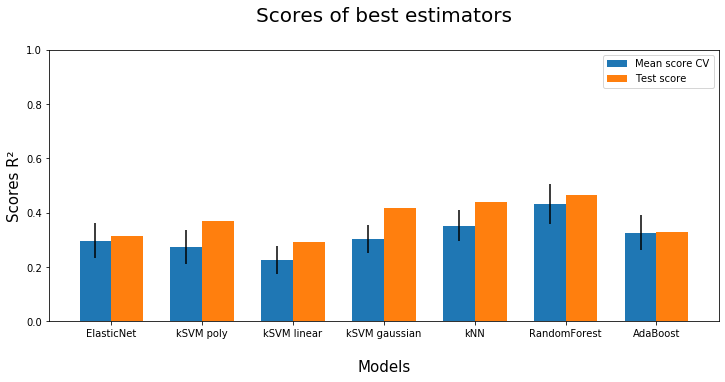

In [25]:
import matplotlib.pyplot as plt

# Plotting with a bar plot
x = np.arange(len(results_df))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,5))
rects1 = ax.bar(x - width/2, results_df['mean_score_CV'], width, yerr=results_df['std_score_CV'], label='Mean score CV')
rects2 = ax.bar(x + width/2, results_df['test_score'], width, label='Test score')

plt.title('Scores of best estimators\n', fontsize = 20)
plt.xlabel('\nModels', fontsize = 15)
plt.ylabel('Scores R²', fontsize = 15)

ax.set_ylim(ymax=1)

plt.xticks(x, results_df.index)
ax.legend();

### Récupération du modèle final (pipeline : pré-traitement + régresseur)

In [26]:
# Initializing best scor
best_score = 0

# Iterating over models
for model, model_CVsearch in CVsearch_dict.items():
    
    # Selecting model with best score
    if model_CVsearch.best_score_ > best_score:
        # Updating best_score and best_model
        best_model_name = model
        best_score = model_CVsearch.best_score_
        best_model = model_CVsearch.best_estimator_

# Display results
print("The overall best cross-validated score is : R² = {:.3f}".format(best_score))
print("The best model is {} with parameters: ".format(best_model_name))

# Getting parameters from param_grid
for parameter, _ in param_grids[best_model_name][0].items():
    if parameter != 'regressor':
        best_parameter = best_model.get_params()[parameter]
        
        # Display best parameter
        parameter = parameter.split("regressor__")[1]
        print("  - " + parameter + ":", best_parameter)


The overall best cross-validated score is : R² = 0.431
The best model is RandomForest with parameters: 
  - n_estimators: 1000
  - max_features: 2


### Évaluation finale sur le jeu de test

In [27]:
score_train = best_model.score(X_train, y_train)
print("Score of the best model ({}) on the train set: R² = {:.3f}".format(best_model_name, score_train))

score_test = best_model.score(X_test, y_test)
print("Score of the best model ({}) on the test set: R² = {:.3f}".format(best_model_name, score_test))

Score of the best model (RandomForest) on the train set: R² = 0.924
Score of the best model (RandomForest) on the test set: R² = 0.464


## **Hybridation des modèles**

### Définition de l'estimateur hybride

In [69]:
from sklearn.base import BaseEstimator, RegressorMixin

# Defining our hybrid regressor
class HybridRegressor(BaseEstimator, RegressorMixin):
    """Custom regressor which predict the mean of predictions by other regressors."""
    
    def __init__(self, list_models, strategy=None):
        self.hybrided_models = list_models
        self.strategy = 'mean'
        
        # set strategy if specified
        if strategy is not None:
            self.strategy = strategy
    
    def fit(self, X, y):
        for model in self.hybrided_models:
            # Should check if self.hybrided_models is modified
            model.fit(X, y)  
        return self
    
    def predict(self, X):
        # initialisation
        predictions = np.zeros((len(self.hybrided_models), len(X)))
        
        # computing prediction for all models
        for index, model in enumerate(self.hybrided_models):
            predictions[index] = model.predict(X)
        
        if self.strategy == 'mean':      
            # computing the mean of predictions
            y_predicted = np.mean(predictions,axis=0) 
        
        if self.strategy == 'median':
            # computing median of predictions
            y_predicted = np.median(predictions,axis=0)
        
        return y_predicted

In [70]:
# Initialising the list of models to hybrid
bestmodels_list = []

# Iteration over models with fitted hyper-parameters
for model, _ in param_grids.items():
    # Adding best model for each algorithm to the list
    bestmodels_list.append(CVsearch_dict[model].best_estimator_)
    
# Defining HybridRegressor from our list of models
hybrid_model = HybridRegressor(bestmodels_list)

In [71]:
# Compute the R²-score on the train set
score_train = hybrid_model.score(X_train, y_train)
print("Score of the hybrid model on the train set: R² = {:.3f}".format(score_train))

# Compute the R²-score on the test set
score_test = hybrid_model.score(X_test, y_test)
print("Score of the hybrid model on the test set: R² = {:.3f}".format(score_test))

Score of the hybrid model on the train set: R² = 0.490
Score of the hybrid model on the test set: R² = 0.463


### Optimisation de l'hybridation
Avec *n* modèles à hybrider, le nombre d'hybridations possible est :

$$ N = \sum\limits_{k=1}^n C_n^k = \sum\limits_{k=1}^n \frac{n!}{k! (n-k)!}$$

Pour n = 5, nous avons déjà 31 hybridations possibles. Plutôt qu'une recherche exhaustive, nous souhaitons déterminer le meilleur modèle hybride possible grâce à une heuristique. Pour cela, nous implémentons un algorithme *forward-backward* descendant.

#### Séparation d'un jeu de validation (ou de développement) à partir du jeu de test

In [31]:
# Splitting the test set in validation set and test set
SIZE = int(len(X_test)/2)

X_valid = X_test[:SIZE]
y_valid = y_test[:SIZE]

X_test = X_test[SIZE:]
y_test = y_test[SIZE:]

In [72]:
# To convert as a function
# Optimisation : performance optimisation by caching results

list_models = bestmodels_list[:]

# Initialization by full hybrid
models_in = list_models[:]
models_out = []
hybrid_model = HybridRegressor(models_in, strategy='median')
best_score = hybrid_model.score(X_valid, y_valid)
iteration = 0
print("Initial score (on validation set) : R² = {:.3f}".format(best_score))

while True:
    model_to_add = []
    model_to_drop = []
    iteration = iteration + 1
    print("\nIteration n°{}".format(iteration))
    
    # Testing if current hybrid model contains at least two models
    if len(models_in)>=2:
        
########## Testing substraction of a model
        print("Trying to substract a model.")
        # Iteration on models in the current hybrid model
        for model in models_in:
            # Copy the list of models in the hybrid model
            models_to_test = models_in[:]
            # Remove a model from the list
            models_to_test.remove(model)
            # Instanciate a new hybrid model
            hybrid_model = HybridRegressor(models_to_test, strategy='median')
            # Evaluate the new hybrid model
            score = hybrid_model.score(X_valid, y_valid)
            # It the new hybrid model is better than previous one
            if score > best_score:
                best_score = score
                model_to_drop = model
                
        # If a new hybrid was better by removing a model
        if model_to_drop:
            models_in.remove(model_to_drop)
            print("Removing model :\n{}".format(model_to_drop.get_params()['regressor']))
            models_out.append(model_to_drop)
            print("New score (on validation set) : R² = {:.3f}".format(best_score))
            continue
        
        # Else
        print("No model substracted to the hybrid.")
    
    # Testing if hybrid is already "full"
    if len(models_in)!=len(list_models):

########## Testing addition of a model
        print("Trying to add a model.")
        # Iteration on models out of the current hybrid model
        for model in models_out:
            # Copy the list of models in the hybrid model
            models_to_test = models_in[:]
            # Add a model to the list
            models_to_test.append(model)
            # Instanciate a new hybrid model
            hybrid_model = HybridRegressor(models_to_test, strategy='median')
            # Evaluate the new hybrid model
            score = hybrid_model.score(X_valid, y_valid)
            # print("Score by trying to add {} : {}".format(model.get_params()['regressor'], score))
            # It the new hybrid model is better than previous one
            if score > best_score:
                best_score = score
                model_to_add = model

        # If a new hybrid was better by adding a model
        if model_to_add:
            models_in.append(model_to_add)
            print("Adding model to the hybrid:\n{}".format(model_to_add.get_params()['regressor']))
            models_out.remove(model_to_add)
            print("New score (on validation set) : R² = {:.3f}".format(best_score))
            continue
            
        # Else
        print("No model added to the hybrid.")
        
        # If no better hybrid was found by removing nor adding a model
        print("\nOptimization completed.")
        print("List of models in the final hybrid :")
        for model in models_in:
            print("   - {}".format(model.get_params()['regressor']))
            
    # Instanciate best hybrid model and evaluate it
    final_model = HybridRegressor(models_in, strategy='median')
    best_score = final_model.score(X_valid, y_valid)
    print("Final score (on validation set) : R² = {:.3f}".format(best_score))
        
    break

Initial score (on validation set) : R² = 0.356

Iteration n°1
Trying to substract a model.
Removing model :
SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
New score (on validation set) : R² = 0.358

Iteration n°2
Trying to substract a model.
Removing model :
AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='square',
                  n_estimators=100, random_state=181)
New score (on validation set) : R² = 0.372

Iteration n°3
Trying to substract a model.
No model substracted to the hybrid.
Trying to add a model.
No model added to the hybrid.

Optimization completed.
List of models in the final hybrid :
   - ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.25,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
   - SVR(C=1, cache_size=2

In [33]:
# Compute the R²-score on the train set
score_train = final_model.score(X_train, y_train)
print("Score of the best hybrid model on the train set: R² = {:.3f}".format(score_train))

# Compute the R²-score on the test set
score_test = final_model.score(X_test, y_test)
print("Score of the best hybrid model on the test set: R² = {:.3f}".format(score_test))

Score of the best hybrid model on the train set: R² = 0.881
Score of the best hybrid model on the test set: R² = 0.527


Le nouveau modèle semble obtenir des résultats légèrement plus élevés que le modèle hybride complet, mais semble aussi souffrir de **sur-apprentissage**, car nous constatons un écart important entre les résultats sur le jeu d'entraînement et ceux sur le jeu de test.

### Comparaison des prédictions et des valeurs réelles (sur le jeu de test)

À convertir en fonction

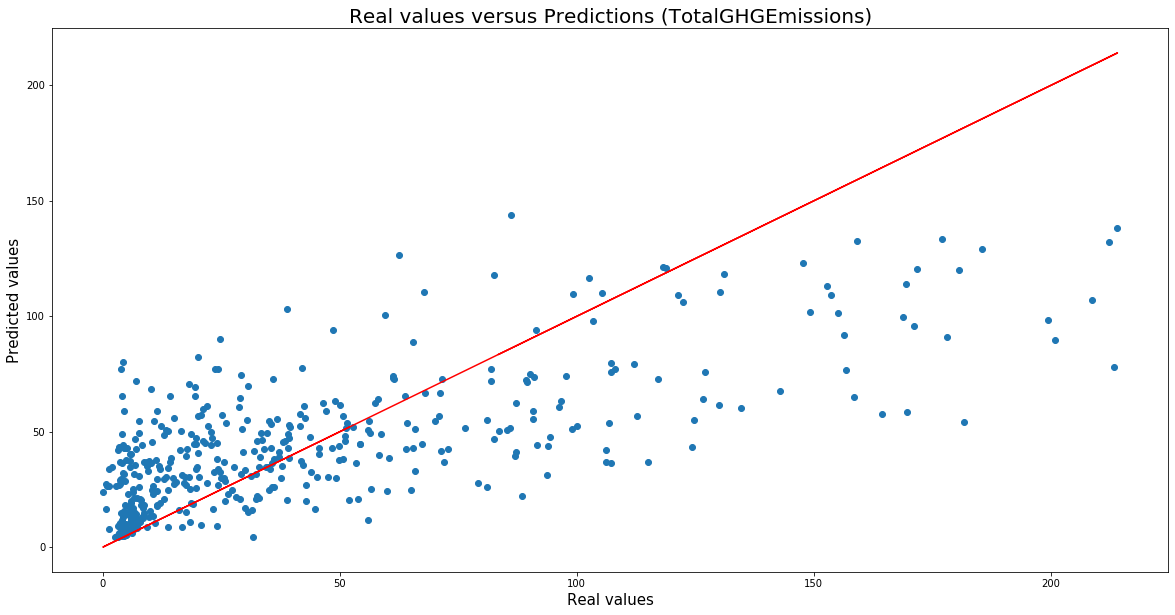

In [34]:
import matplotlib.pyplot as plt

# Defining the real values for target feature
y_real = y_test

# Calculating predictions on testing set
y_predicted = final_model.predict(X_test)

# Setting parameters of the plot
fig = plt.figure(figsize=(20, 10))
plt.title('Real values versus Predictions ({})'.format(target_feature), fontsize=20)
plt.xlabel('Real values', fontsize=15)
plt.ylabel('Predicted values', fontsize=15)

# Plotting the scatter plot
plt.scatter(y_real, y_predicted)

# Plotting the x=y line
plot = plt.plot(y_real, y_real, color='red')

Nous constatons que notre modèle est à la peine avec les **valeurs hors-normes** qui sont mal évaluées. Nous allons regarder si l'élimination de ces valeurs hors-normes dans le jeu d'entraînement permet d'améliorer les performances de notre modèle.

## **Impact des valeurs hors-normes** ("*outliers*")
Nous allons tester si le modèle est plus performant lorsque l'on élimine les valeurs hors-normes du jeu d'entraînement.

### Détection des valeurs hors-normes
Nous utilisons la méthode de l'intervalle inter-quartile.

À convertir en fonction

In [35]:
# Setting parameters
series = y_train

# Computing first and third quartiles and inter-quartile range
Q1 = series.quantile(q=0.25, interpolation='linear')   # first quartile
Q3 = series.quantile(q=0.75, interpolation='linear')   # third quartile
IQR = Q3 - Q1

# definition of mask
mask = (series < Q1 - 1.5*IQR) | (series > Q3 + 1.5*IQR)

# Calling the function to get the outliers
outliers = series[mask]

# Displays number of outliers
print("Number of detected outliers:", len(outliers))

Number of detected outliers: 118


### Suppression des valeurs hors-norme du jeu d'entraînement

In [36]:
# Drop outiers from X_train and y_train
X_train_without_outliers = X_train[~mask]
y_train_without_outliers = y_train[~mask]

### Ré-entraînement du modèle

In [37]:
# Training the "final pipeline" on the data without outliers
final_model.fit(X_train_without_outliers, y_train_without_outliers);

### Ré-évaluation du modèle sans les valeurs hors-normes ("*outliers*")

In [38]:
# Compute the R²-score on the train set
score_train = final_model.score(X_train_without_outliers, y_train_without_outliers)
print("Score of the final model (trained without outliers) on the train set: R² = {:.3f}".format(score_train))

# Compute the R²-score on the test set
score_test = final_model.score(X_test, y_test)
print("Score of the final model (trained without outliers) on the test set: R² = {:.3f}".format(score_test))

Score of the final model (trained without outliers) on the train set: R² = 0.870
Score of the final model (trained without outliers) on the test set: R² = 0.437


Nous constatons que l'élimination des valeurs hors-normes du jeu d'entraînement ne **permet pas d'améliorer les performances du modèle**. Au contraire, le modèle ne pouvant plus apprendre de ces valeurs, il est encore moins performant pour effectuer des prédictions sur le jeu de test.

## **Effets de la taille du jeu de données d'entraînement**
Nous étudions l'impact de la taille du jeu de données d'entraînement pour déterminer si notre modèle gagnerait en exactitude à être entraîné sur un nombre plus important de données. Autrement dit : la ville de Seattle pourrait-elle déjà utiliser le modèle, ou devrait-elle continuer à collecter des données ?

Pour obtenir les résultats les plus fiables possibles, et estimer la variance de nos résultats, nous allons utiliser une **validation croisée**.

### Définition du générateur de validation croisée

In [39]:
from sklearn.model_selection import KFold

# Define the cross-validation generator
cv_learning = KFold(
    n_splits=10, # number of folds (default=5)
    shuffle=True, # shuffle the data before splitting into batche
    random_state=seed, # seeding the random number generator for shuffling
)

### Évaluation du modèle sur des jeux d'entraînement de taille croissante

In [40]:
from sklearn.model_selection import learning_curve

# Create CV training and test scores for various training test sizes
train_sizes, train_scores, test_scores = learning_curve(
    best_model, # estimator
    X, # features
    y, # target
    cv=cv_learning, # cross-validation generator
    scoring='r2', # performance metric
    n_jobs=-1, # use all computer cores
    train_sizes=np.linspace(0.01, 0.99, 50), # 50 training sets
)

### Calcul des moyennes et écarts-types

In [41]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

### Courbe d'apprentissage

In [42]:
# We change negative values to zero to avoid crushing the graph
train_mean = [0 if score < 0 else score for score in train_mean]
test_mean = [0 if score < 0 else score for score in test_mean]

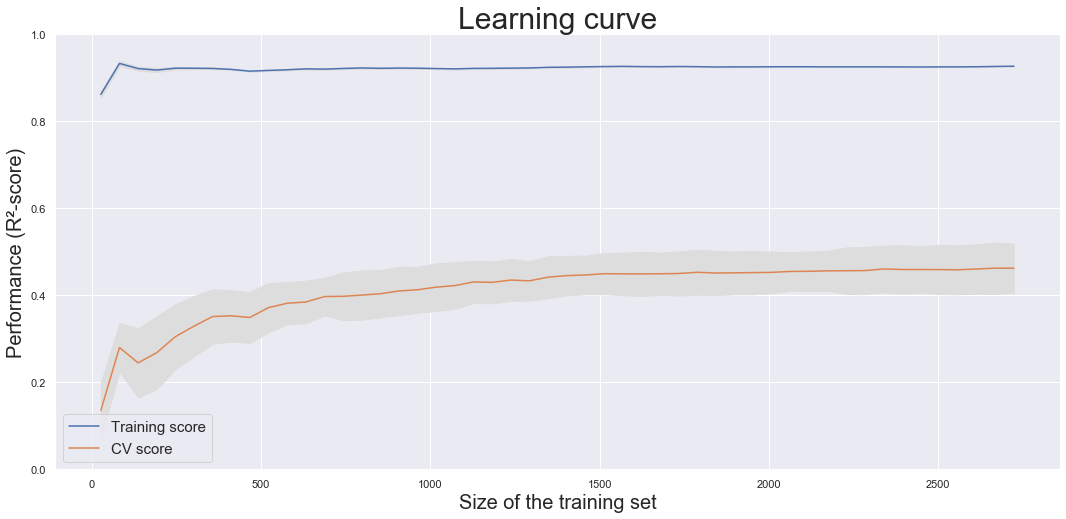

In [43]:
# Loading libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()

# Setting main properties
fig, ax = plt.subplots(figsize=(18, 8))
plt.title("Learning curve", fontsize=30)
plt.xlabel("Size of the training set", fontsize=20)
plt.ylabel("Performance (R²-score)", fontsize=20)
ax.set_ylim(ymax=1)

# Draw bands (for standard deviation)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Graphing the plot
ax.plot(train_sizes, train_mean, label='Training score')
ax.plot(train_sizes, test_mean, label='CV score')
plt.legend(loc='best', fontsize=15);

## **Importance des caractéristiques**
Les modèles que nous avons étudiés, et qui composent notre estimateur hybride, ne permettent pas tous d'inspecter l'importance relative des features, mais certains le peuvent.

### Importance des caractéristiques : ElasticNet

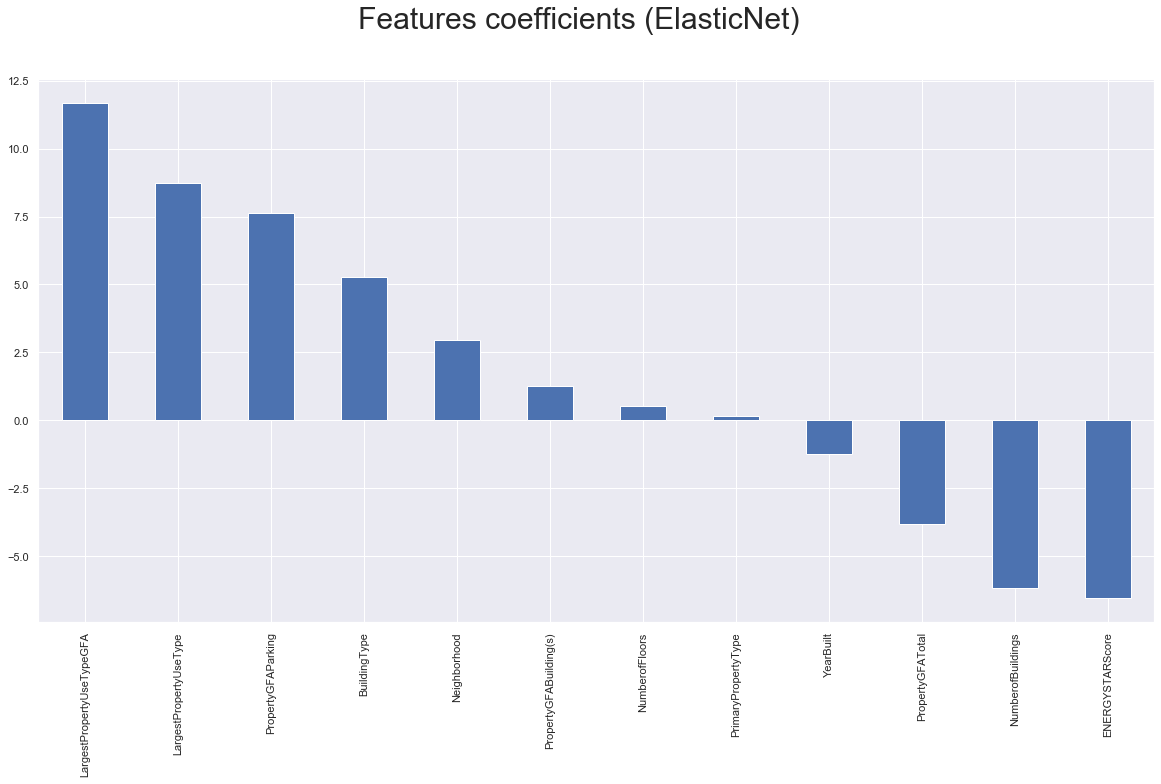

In [44]:
# Features importance for linear model (ElasticNet)
features_coeff = CVsearch_dict['ElasticNet'].best_estimator_.get_params()['regressor'].coef_

# Getting name of features
features_names = list(X)

# Creating a Pandas Series
features_importance = pd.Series(features_coeff, features_names)

# Sorting the pd.Series in descending order
features_importance = features_importance.sort_values(ascending=False)

# Plotting a barplot using the pandas.plot method
plot = features_importance.plot(kind="bar", figsize=(20,10))

# Setting title for the plot
import pylab as pl
pl.suptitle("Features coefficients (ElasticNet)", fontsize=30);

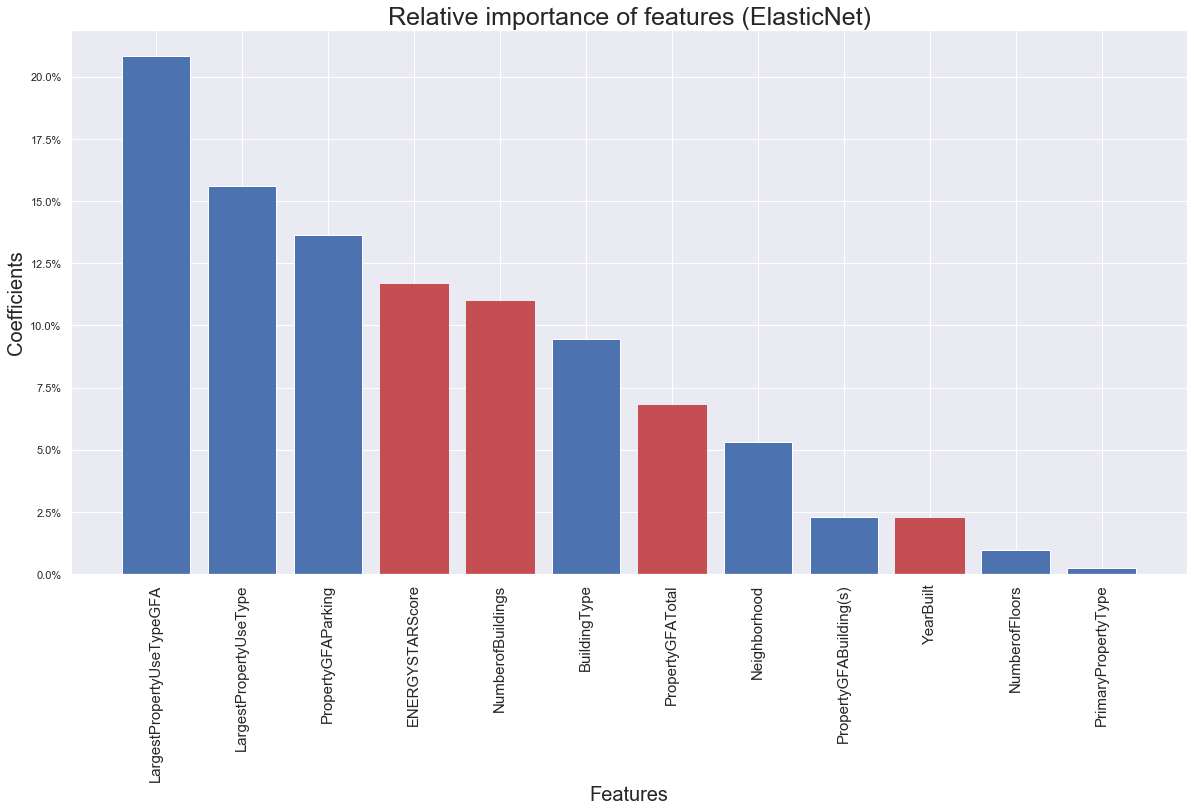

In [45]:
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()

# Calculating absolute value for each coefficient
abs_coeffs = list(map(abs, features_coeff))

# Getting the list of features with negative coefficients
mask = features_coeff < 0
neg_features = [feature_name for (feature_name, mask_value) in zip(features_names, mask) if mask_value == True]

# Summing the absolute values of coefficients
from functools import reduce
sum_coeffs = reduce((lambda x, y: x + y), abs_coeffs, 0)

# Computing relative importance
relative_coeffs = abs_coeffs/sum_coeffs

# Creating lists of tuples (feature, relative coefficient)
list_features_coeff = []
for feature_name, relative_coeff in zip(features_names, relative_coeffs):
    list_features_coeff.append((feature_name, relative_coeff))
    
# Sorting the list by coefficient, in reversed order (descending)
list_features_coeff.sort(key=lambda tup: tup[1], reverse=True)

# Getting ordered list of features and relative coefficients
features_names = [tup[0] for tup in list_features_coeff]
features_coeff = [tup[1] for tup in list_features_coeff]

# Getting the index of features with negative coefficients
neg_features_index_list = [index for (index, tup) in enumerate(list_features_coeff) if tup[0] in neg_features]

# Plotting a barplot for the coefficients of features
fig, ax = plt.subplots(figsize=(20, 10))
plt.xticks(range(len(features_coeff)), features_names, rotation='vertical', fontsize=15)
plt.title("Relative importance of features (ElasticNet)", fontsize=25)
plt.xlabel("Features", fontsize=20)
plt.ylabel("Coefficients", fontsize=20)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
barlist= plt.bar(range(len(features_coeff)),features_coeff)

# Set red color bar for features with negative coefficients
for index in neg_features_index_list:
    barlist[index].set_color('r')

### Importance des caractéristiques : Forêt Aléatoire

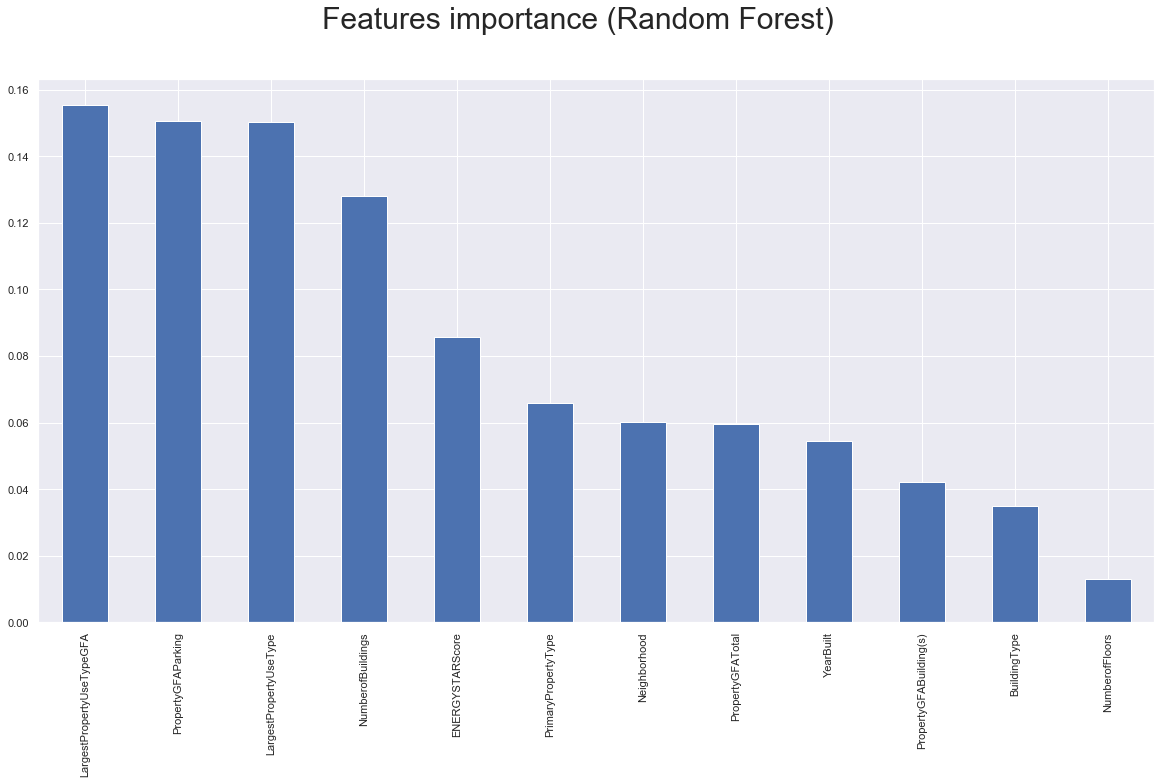

In [46]:
import matplotlib.ticker as ticker

# Features importance for linear model (ElasticNet)
features_importances = CVsearch_dict['RandomForest'].best_estimator_.get_params()['regressor'].feature_importances_

# Getting name of features
features_names = list(X)

# Creating a Pandas Series
features_importance = pd.Series(features_importances, features_names)

# Sorting the pd.Series in descending order
features_importance = features_importance.sort_values(ascending=False)

# Plotting a barplot using the pandas.plot method
plot = features_importance.plot(kind="bar", figsize=(20,10))

# Setting title for the plot
import pylab as pl
pl.suptitle("Features importance (Random Forest)", fontsize=30);

### Importance des caractéristiques : AdaBoost

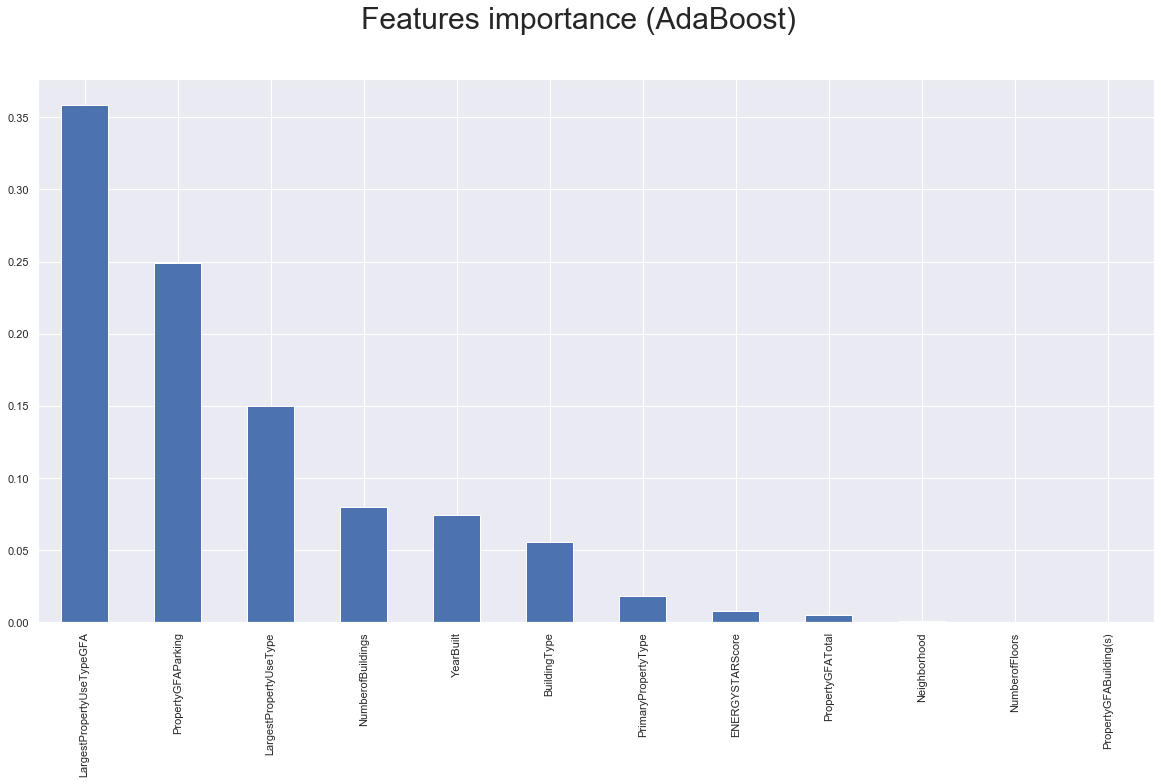

In [47]:
# Features importance for linear model (ElasticNet)
features_importances = CVsearch_dict['AdaBoost'].best_estimator_.get_params()['regressor'].feature_importances_

# Getting name of features
features_names = list(X)

# Creating a Pandas Series
features_importance = pd.Series(features_importances, features_names)

# Sorting the pd.Series in descending order
features_importance = features_importance.sort_values(ascending=False)

# Plotting a barplot using the pandas.plot method
plot = features_importance.plot(kind="bar", figsize=(20,10))

# Setting title for the plot
import pylab as pl
pl.suptitle("Features importance (AdaBoost)", fontsize=30);

## Intérêt de la variable **'ENERGY STAR Score'**

Nous cherchons en particulier à évaluer l'intérêt de l’'ENERGY STAR Score' ([www.energystar.gov](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what)) pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par l'équipe.
* 'ENERGYSTARScore' : An EPA calculated 1-100 rating that assesses a property’s overall energy performance, based on national data to control for differences among climate, building uses, and operations. A score of 50 represents the national median.

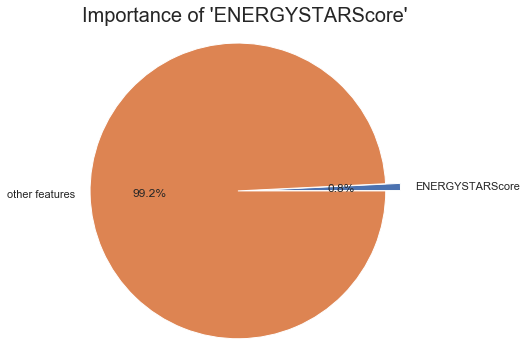

In [48]:
import matplotlib.pyplot as plt

# Computing relatives importances of all features
relative_importances = features_importance.abs() / features_importance.abs().sum()

# Setting labels of the pie-plot
labels = ['ENERGYSTARScore', 'other features']

# Getting the relative importance of 'ENERGYSTARScore'
sizes = [relative_importances.loc['ENERGYSTARScore'], 1-relative_importances.loc['ENERGYSTARScore']]

# only "explode" the 'ENERGYSTARScore' slice
explode = (0.1, 0) 

fig1, ax1 = plt.subplots(figsize=(6, 6))

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Importance of 'ENERGYSTARScore' (AdaBoost)", fontsize=20)
plt.show()

### Ré-entraînement du modèle final sans la variable 'ENERGYSTARScore'

In [49]:
# Evaluating the performance of the model withthe 'ENERGYSTARScore' feature
score_test = final_model.score(X_test, y_test)
print("The score of the model with 'ENERGYSTARScore' is : R² = {:.3f}".format(score_test))

The score of the model with 'ENERGYSTARScore' is : R² = 0.437


In [50]:
# Getting the input data without 'ENERGYSTARScore'
mask = X_train.columns != 'ENERGYSTARScore'
X_train_wo_ENERGIE = X_train.loc[:, mask]
X_test_wo_ENERGIE = X_test.loc[:, mask]

In [51]:
def build_adapted_model(X):
    """This function adapt the current best model (best algorithm with its fitted hyper-parameters)
    to data sets of new shape (new features and so on.).
    Mainly for pre-processing compatibility purpose."""
    
    # Rebuilt preprocessing step from this
    preprocessor = define_preprocessor(X)

    # Getting best_model parameters
    best_regressor = best_model.get_params()['regressor']

    # Rebuilt pipeline from this
    adapted_model = define_pipeline(preprocessor, best_regressor)
    
    # Return the adapted model
    return adapted_model

In [52]:
# Building a model without ENERGIEStarScore
adapted_model = build_adapted_model(X_train_wo_ENERGIE)

# Training the model without the 'ENERGYSTARScore' feature
adapted_model.fit(X_train_wo_ENERGIE, y_train)

# Re-evaluating the performance of the model without the 'ENERGYSTARScore' feature with cross-validation
score_wo_test = adapted_model.score(X_test_wo_ENERGIE, y_test)
print("The score of the final model without 'ENERGYSTARScore' is : R² = {:.3f}".format(score_wo_test))

# Getting back the final model
final_model = build_adapted_model(X)
final_model.fit(X_train, y_train) ;

The score of the final model without 'ENERGYSTARScore' is : R² = 0.515


## **Ré-entraînement final et sauvegarde du modèle**
Nous ré-entraînons le modèle avec les les hyperparamètres sélectionnés, sur l'ensemble du jeu de données pour lequel nous disposons des étiquettes cibles : le jeu de données d'entraînement et le jeu de données de test.

Nous sauvegardons le modèle dans un fichier pickle pour usage ultérieur, en indiquant dans le nom du fichier la version de scikit-learn.

In [53]:
# Re-training the final model on the whole set
final_model.fit(X, y)

# Load libraries
import sklearn
import joblib

# Get scikit-learn version
scikit_version = sklearn.__version__

# Save model as pickle file
joblib.dump(final_model, "model_{version}.pkl".format(version=scikit_version))

['model_0.21.2.pkl']

## **Mise en production**
Nous ne disposons que de quelques observations non-étiquettées sur lesquelles utiliser notre modèle pour estimer la consommation d'énergie et/ou l'émission de gaz à effets de serre. Cela nous permet néanmoins de valider le flux de données.

### Chargement du modèle

In [54]:
# Load model from file
try:
    final_model = joblib.load("model_0.21.2.pkl")
except:
    final_model = joblib.load("model_0.20.3.pkl")

### Élimination des colonnes d'étiquettes
   Afin d'avoir un jeu de données ayant le même format que le jeu d'entraînement.

In [55]:
production_set = production_set.drop(target_cols, axis=1)

### Prédictions sur les données non-étiquettées

In [56]:
# Using prediction of best model
final_model.predict(production_set)

array([120.250765,  13.904975,  11.965145,  22.005115])

### Suppression du dossier de cache

In [57]:
from shutil import rmtree

# Clear the cache directory when you don't need it anymore
rmtree(cachedir)

# **Pistes d'améliorations**

# **TO DO LIST**
* faire un modèle compatible avec une modification du nombre de features : 
    * energystar score,
    * variables polynomiales,
    * variables mesurées (que l'on ne voudrait plus mesurer…),
    * longitude et latitude…


* Bootstrap au lieu de validation croisée imbriquée pour l'évaluation finale
* Faire une ACP en plus de la t-SNE
* Heatmap pour les cas où il y a 2 hyper-paramètres

# <span style="color:red">**TO FIX LIST**</span>
* problème de version sklearn : essayer avec pip au lieu de conda, hors anaconda
* Normaliser les variables cibles avec Box-Cox
* Distribution empirique : avec Seaborn
* feature engineering sur les variables explicatives (???)
* marges d'erreur ou intervalle de confiance de la valeur estimée. Possible ?
* suppression des outliers avant le split train_set et test_set : ok ?
* modèle hybride ne fonctionne pas avec la validation croisée
* incompatibilité du bayesian optimiser (skopt) avec sklearn 0.21